In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns 


In [ ]:

df = pd.read_csv('ctcdata.csv')
df.describe()

In [ ]:
df.head()

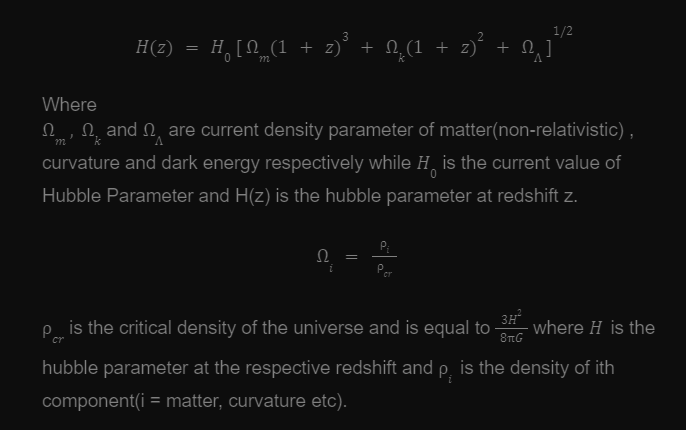

```H(z) = H0 [ Omega_m*(1 + z)**3 + k*(1 + z)**2 + Omega_A ]**0.5```  

H0 =  73.04 +/- 1.04 km s-1Mpc-1  
**Given a dataset for Hubble parameter at various redshifts, constrain and find the best fit values for Omega_m , Omega_k and plot 1 and 2D marginalized probability distributions for all three parameters and report uncertainty corresponding to 1,2 and 3**



In [ ]:
h0 =  73.04; e0 = 1.04; h0u = h0 + e0; h0l = h0 - e0 

df.columns = ['z', 'hz', 'e']
df.head()

```Sqrt( H(z)/H0 ) = A*Omega_m + B*Omega_k + Omega_l```  
```Sqrt( H(z)/H0 ) = a*m + b*k + l```

In [ ]:
df['a'] = (1+df['z'])**3
df['b'] = (1+df['z'])**2
df['hz-2'] = ((df['hz']-df['e'])/(h0+e0))**2
df['hz-1'] = ((df['hz']-df['e'])/(h0-e0))**2
df['hz0'] = ((df['hz']/h0))**2
df['hz1'] = ((df['hz']+df['e'])/(h0+e0))**2
df['hz2'] = ((df['hz']+df['e'])/(h0-e0))**2
# Add a column of hz1.5 = (hz1+hz2)/2 and hz-1.5 = (hz-1+hz-2)/2
df['hz1.5'] = (df['hz1'] + df['hz2'])/2
df['hz-1.5'] = (df['hz-1'] + df['hz-2'])/2
df['hzu'] = df['hz0'] +1.5*(df['hz2'] - df['hz0'])
df['hzl'] = df['hz0'] -1.5*(df['hz0'] - df['hz-2'])
df.head()

In [71]:
# H(z) = H0 [ Omega_m*(1 + z)**3 + k*(1 + z)**2 + Omega_A ]**0.5
# H0 =  73.04 +/- 1.04 km s-1Mpc-1 

# Thus, we can write the equation as:
#  Omega_m*(1 + z)**3 + k*(1 + z)**2 + Omega_A = (H(z)/H0)**2
## Sq( H(z)/H0 ) = A*Omega_m + B*Omega_k + Omega_l  
## Sq( H(z)/H0 ) = a*m + b*k + l

# hz-2 is the lower error bar
# hz+2 is the upper error bar
# hz0 is the central value
# a = (1+z)**3
# b = (1+z)**2
# l = Omega_l
# m = Omega_m
# k = Omega_k

def model(z, m, k, l):
    return (m*(1+z)**3 + k*(1+z)**2 + l)

def chi2(m, k, l):
    return np.sum((df['hz0'] - model(df['z'], m, k, l))**2)

def plot_tolerances(m, k, l):
    plt.plot(df['z'], df['hz0'], 'o', label='data')
    z = np.linspace(0, 2, 100)
    plt.plot(z, model(z, m, k, l), label='best fit model')
    plt.fill_between(df['z'], df['hzl'], df['hzu'], color='gray', alpha=0.5)
    plt.xlabel('z')
    plt.ylabel('H(z)/H0')
    plt.legend()
    plt.show()
    


Find the initial value of the parameters. Choose 3 rows from the data with minimum error and calculate the value of m, k, and l by solving the 3 linear equations.  
```Sq(H(z)/H0) = a*m + b*k + l```  
```Sq(H(z)/H0) = a1*m + b1*k + l```  
```Sq(H(z)/H0) = a2*m + b2*k + l```  

```m = (a1*b2 - a2*b1)/(a*b2 - a2*b)```  
```k = (a*b1 - a1*b)/(a*b2 - a2*b)```  
```l = (a1*b - a*b1)/(a*b2 - a2*b)```  

```a = Sq(H(z1)/H0)```  
```b = Sq(H(z2)/H0)```  
```a1 = Sq(H(z3)/H0)```  
```b1 = (1+z1)**2```  
```a2 = (1+z2)**2```  
```b2 = (1+z3)**2```  
  
Thus  
```m = (a1*(1+z3)**2 - (1+z2)**2*Sq(H(z3)/H0))/(Sq(H(z1)/H0)*(1+z3)**2 - (1+z2)**2*Sq(H(z1)/H0))```  
```k = (Sq(H(z1)/H0)*(1+z3)**2 - a1*(1+z2)**2)/(Sq(H(z1)/H0)*(1+z3)**2 - (1+z2)**2*Sq(H(z1)/H0))```  
```l = (a1*(1+z2)**2*Sq(H(z1)/H0) - Sq(H(z1)/H0)*(1+z2)**2*Sq(H(z3)/H0))/(Sq(H(z1)/H0)*(1+z3)**2 - (1+z2)**2*Sq(H(z1)/H0))```  


In [17]:
_ = '''```Sq(H(z)/H0) = a*m + b*k + l```  
```Sq(H(z)/H0) = a1*m + b1*k + l```   
```Sq(H(z)/H0) = a2*m + b2*k + l```   
  '''
df.sort_values(by='e').head() 
# 4,5, 9 are the lowest errors 


,z,hz,e,a,b,hz-2,hz-1,hz0,hz1,hz2,hz1.5,hz-1.5,hzu,hzl
4,0.179,75.0,4.0,1.638858,1.390041,0.918575,0.972415,1.054389,1.137240,1.203897,1.170568,0.945495,1.278650,0.850668
5,0.199,75.0,5.0,1.723684,1.437601,0.892882,0.945216,1.054389,1.166213,1.234568,1.200391,0.919049,1.324657,0.812129
9,0.350,76.3,5.6,2.460375,1.822500,0.910829,0.964215,1.091258,1.222266,1.293906,1.258086,0.937522,1.395230,0.820614
15,0.600,87.9,6.1,4.096000,2.560000,1.219283,1.290748,1.448292,1.610103,1.704475,1.657289,1.255016,1.832567,1.104779
17,0.730,97.3,7.0,5.177717,2.992900,1.485845,1.572934,1.774615,1.982288,2.098474,2.040381,1.529390,2.260404,1.341460


In [19]:

m = (df['a'].iloc[5]*df['b'].iloc[9] - df['a'].iloc[9]*df['b'].iloc[5])/(df['a'].iloc[4]*df['b'].iloc[9] - df['a'].iloc[9]*df['b'].iloc[4])
k = (df['a'].iloc[4]*df['b'].iloc[9] - df['a'].iloc[5]*df['b'].iloc[4])/(df['a'].iloc[4]*df['b'].iloc[9] - df['a'].iloc[9]*df['b'].iloc[4])
l = (df['a'].iloc[5]*df['b'].iloc[4]*df['hz0'].iloc[4] - df['a'].iloc[4]*df['b'].iloc[5]*df['hz0'].iloc[5])/(df['a'].iloc[4]*df['b'].iloc[9] - df['a'].iloc[9]*df['b'].iloc[4])

print(m, k, l)



0.9132540206826573 -1.3638610962706268 -0.09727600182599916


X_matrix: [ 0.73432639 -1.309702    1.67147187]
True


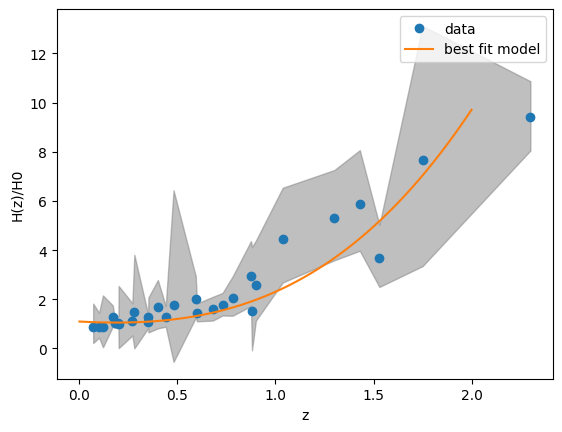

In [29]:

# Y_matrix = np.array([df['hz0'].iloc[4], df['hz0'].iloc[5], df['hz0'].iloc[9]]).T
# # Y = MX
# M_matrix = np.array([   [df['a'].iloc[4], df['b'].iloc[4], 1], 
#                         [df['a'].iloc[5], df['b'].iloc[5], 1], 
#                         [df['a'].iloc[9], df['b'].iloc[9], 1]])

# X = np.linalg.solve(M_matrix, Y_matrix)
# print(X)
def solve_rows(row1, row2, row3):
    Y_matrix = np.array([df['hz0'].iloc[row1], df['hz0'].iloc[row2], df['hz0'].iloc[row3]]).T
    M_matrix = np.array([   [df['a'].iloc[row1], df['b'].iloc[row1], 1], 
                            [df['a'].iloc[row2], df['b'].iloc[row2], 1], 
                            [df['a'].iloc[row3], df['b'].iloc[row3], 1]])
    X = np.linalg.solve(M_matrix, Y_matrix)
    yield X
    Y_confirm = np.matmul(M_matrix, X)
    yield np.allclose(Y_matrix, Y_confirm)
f = solve_rows(4, 5, 9)
X = next(f)
print(f'X_matrix: {X}')
# print(X)
print(next(f))
plot_tolerances(*X)
# print(f'Y_matrix: {Y_matrix}')
# print(f'Y_confirm: {Y_confirm}')
# print(np.allclose(Y_matrix, Y_confirm))

X: [ 0.73432639 -1.309702    1.67147187]
Initial loss_ul: 3.3231317991280576
0) Best fit values of m, k, and l:[0.11421124 0.51033224 0.23751702]
1) Best fit values of m, k, and l:[0.13719332 0.42949353 0.1176224 ]
1.5) Best fit values of m, k, and l:[ 0.03312806  0.70322813 -0.10322721]
2) Best fit values of m, k, and l:[0.20361958 0.25046414 0.2840135 ]
               m      k      l  Loss_0  Loss_1  Loss_1_5  Loss_2  Var_m  \
Loss used                                                                 
Loss_0     0.114  0.510  0.238  12.674   2.894     1.335   1.849  0.065   
Loss_1     0.137  0.429  0.118  12.166   2.432     0.729   1.063  0.033   
Loss_1_5   0.033  0.703 -0.103  13.071   2.851     0.659   1.179  0.018   
Loss_2     0.204  0.250  0.284  12.265   2.854     0.885   1.060  0.013   

           Var_k  Var_l  Loss_U_L  
Loss used                          
Loss_0     0.461  0.303     0.776  
Loss_1     0.372  0.460     0.063  
Loss_1_5   0.239  0.516     0.000  
Loss_2     

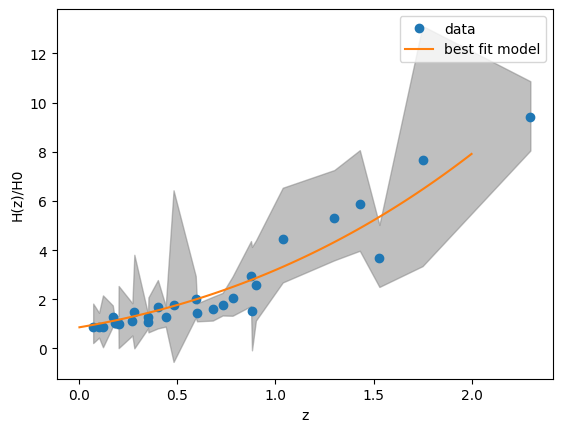

For loss_1


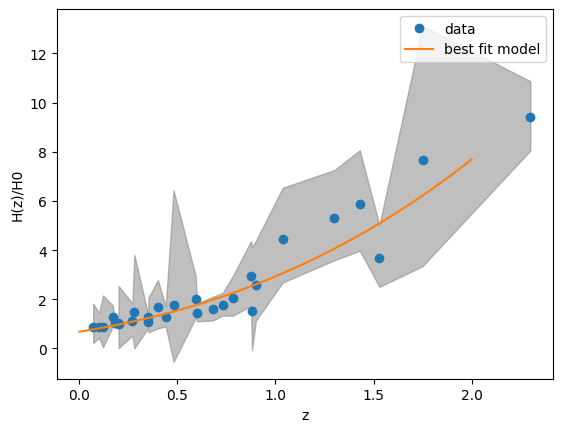

For loss_1.5


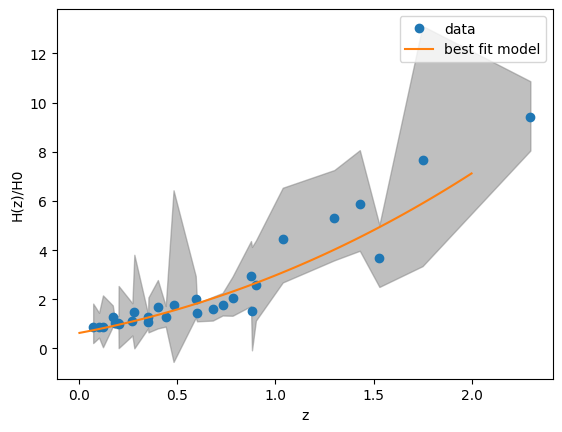

For loss_2


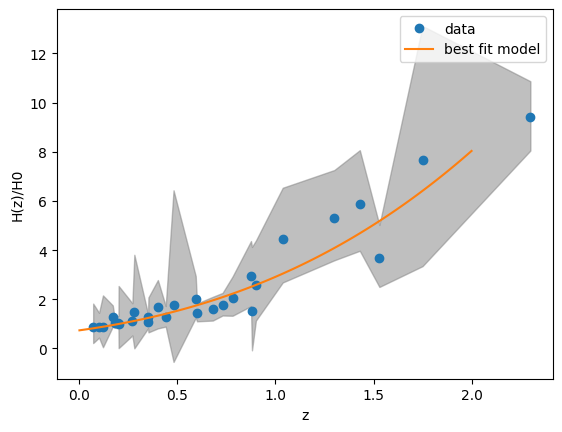

,m,k,l,Loss_0,Loss_1,Loss_1_5,Loss_2,Var_m,Var_k,Var_l,Loss_U_L
Loss used,,,,,,,,,,,
Loss_0,0.114,0.510,0.238,12.674,2.894,1.335,1.849,0.065,0.461,0.303,0.776
Loss_1,0.137,0.429,0.118,12.166,2.432,0.729,1.063,0.033,0.372,0.460,0.063
Loss_1_5,0.033,0.703,-0.103,13.071,2.851,0.659,1.179,0.018,0.239,0.516,0.000
Loss_2,0.204,0.250,0.284,12.265,2.854,0.885,1.060,0.013,0.200,0.459,0.159


In [38]:

# Now initialize the parameters with the values of m, k, and l, define loss function and use gradient descent to minimize the loss function
def loss_0(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        loss[i] = abs(v[i] - df['hz0'][i])
    return np.sum(loss) 

def loss_1(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        if v[i] > df['hz1'][i]:
            loss[i] = (v[i] - df['hz1'][i])
        elif v[i] < df['hz-1'][i]:
            loss[i] = (df['hz-1'][i] - v[i])
        else:
            loss[i] = 0
    return np.sum(loss)

def loss_1_5(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        if v[i] > df['hz1.5'][i]:
            loss[i] = (v[i] - df['hz1.5'][i])**1.8
        elif v[i] < df['hz-1.5'][i]:
            loss[i] = (df['hz-1.5'][i] - v[i])**1.8
        else:
            loss[i] = 0
    return np.sum(loss)

def loss_2(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        if v[i] > df['hz2'][i]:
            loss[i] = (v[i] - df['hz2'][i])
        elif v[i] < df['hz-2'][i]:
            loss[i] = (df['hz-2'][i] - v[i])
        else:
            loss[i] = 0
    return np.sum(loss)

def loss_ul(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        if v[i] > df['hzu'][i]:
            loss[i] = (v[i] - df['hzu'][i])
        elif v[i] < df['hzl'][i]:
            loss[i] = (df['hzl'][i] - v[i])
        else:
            loss[i] = 0
    return np.sum(loss)

from scipy.optimize import minimize
def fit_values(X):
    print(f'X: {X}')
    print(f'Initial loss_ul: {loss_ul(X)}')
    result_0 = minimize(loss_0, X)
    # Report the variance of the parameters
    print(f'0) Best fit values of m, k, and l:{result_0.x}')
    # print(f'Loss_0 = {loss_0(result_0.x)};\n Loss_1 = {loss_1(result_0.x)};\n loss_1_5 = {loss_1_5(result_0.x)};\n Loss_2 = {loss_2(result_0.x)}')
    # print(f'Variance of m: {result_0.hess_inv[0,0]}, Variance of k = {result_0.hess_inv[1,1]}, Variance of l = {result_0.hess_inv[2,2]}\n')

    result_1 = minimize(loss_1, X)
    print(f'1) Best fit values of m, k, and l:{result_1.x}')
    # print(f'Loss_0 = {loss_0(result_1.x)};\n Loss_1 = {loss_1(result_1.x)};\n loss_1_5 = {loss_1_5(result_1.x)};\n Loss_2 = {loss_2(result_1.x)}')
    # print(f'Variance of m: {result_1.hess_inv[0,0]}, Variance of k = {result_1.hess_inv[1,1]}, Variance of l = {result_1.hess_inv[2,2]}\n')

    result_1_5 = minimize(loss_1_5, X)
    print(f'1.5) Best fit values of m, k, and l:{result_1_5.x}')
    # print(f'Loss_0 = {loss_0(result_1_5.x)};\n Loss_1 = {loss_1(result_1_5.x)};\n loss_1_5 = {loss_1_5(result_1_5.x)};\n Loss_2 = {loss_2(result_1_5.x)}')
    # print(f'Variance of m: {result_1_5.hess_inv[0,0]}, Variance of k = {result_1_5.hess_inv[1,1]}, Variance of l = {result_1_5.hess_inv[2,2]}\n')

    result_2 = minimize(loss_2, X)
    print(f'2) Best fit values of m, k, and l:{result_2.x}')
    # print(f'Loss_0 = {loss_0(result_2.x)};\n Loss_1 = {loss_1(result_2.x)};\n loss_1_5 = {loss_1_5(result_2.x)};\n Loss_2 = {loss_2(result_2.x)}')
    # print(f'Variance of m: {result_2.hess_inv[0,0]}, Variance of k = {result_2.hess_inv[1,1]}, Variance of l = {result_2.hess_inv[2,2]}\n')


    # Tabulate the results using dataframes
    # Rows: Loss_0, Loss_1, Loss_1_5, Loss_2
    # Columns: Best fit values of m, k, and l; Loss_0, Loss_1, Loss_1_5, Loss_2; Variance of m, k, and l, Everything rounded to 3 decimal places
    df_results = pd.DataFrame({'m':[result_0.x[0], result_1.x[0], result_1_5.x[0], result_2.x[0]],
                        'k':[result_0.x[1], result_1.x[1], result_1_5.x[1], result_2.x[1]],
                        'l':[result_0.x[2], result_1.x[2], result_1_5.x[2], result_2.x[2]],
                        'Loss_0':[loss_0(result_0.x), loss_0(result_1.x), loss_0(result_1_5.x), loss_0(result_2.x)], 
                        'Loss_1':[loss_1(result_0.x), loss_1(result_1.x), loss_1(result_1_5.x), loss_1(result_2.x)], 
                        'Loss_1_5':[loss_1_5(result_0.x), loss_1_5(result_1.x), loss_1_5(result_1_5.x), loss_1_5(result_2.x)], 
                        'Loss_2':[loss_2(result_0.x), loss_2(result_1.x), loss_2(result_1_5.x), loss_2(result_2.x)], 
                        'Var_m':[result_0.hess_inv[0,0], result_1.hess_inv[0,0], result_1_5.hess_inv[0,0], result_2.hess_inv[0,0]],
                        'Var_k':[result_0.hess_inv[1,1], result_1.hess_inv[1,1], result_1_5.hess_inv[1,1], result_2.hess_inv[1,1]],
                        'Var_l':[result_0.hess_inv[2,2], result_1.hess_inv[2,2], result_1_5.hess_inv[2,2], result_2.hess_inv[2,2]],
                        'Loss_U_L':[loss_ul(result_0.x), loss_ul(result_1.x), loss_ul(result_1_5.x), loss_ul(result_2.x)]
                        })
    #THE last column must be hilighted
    df_results = df_results.round(3)
    df_results.style.highlight_max(color = 'lightgreen', axis = 0)
    df_results.index = ['Loss_0', 'Loss_1', 'Loss_1_5', 'Loss_2']
    # The origin cell must say - 'Method'
    df_results.index.name = 'Loss used'

    # print(df_results)
    df_results.to_csv('results_1.csv')
    # Show df_results
    print(df_results)
    
    print('For loss_0')
    plot_tolerances(result_0.x[0], result_0.x[1], result_0.x[2])
    print('For loss_1')
    plot_tolerances(result_1.x[0], result_1.x[1], result_1.x[2])
    print('For loss_1.5')
    plot_tolerances(result_1_5.x[0], result_1_5.x[1], result_1_5.x[2])
    print('For loss_2')
    plot_tolerances(result_2.x[0], result_2.x[1], result_2.x[2])
    return df_results

fit_values(X)

## Another methos from scratch

### Training a regression model to predict the value of H(z) for a given redshift z

Coefficients of a and b: (0.05816596738860086, 0.7215457727583325)
Intercept: -0.15970339709736026
Coefficients of the polynomial regression lr: [ 0.         -1.01086496  3.84430015 -0.79429996]
Intercept: 1.115511201120713
c3, c2, c1, c0: [ 0.         -1.01086496  3.84430015 -0.79429996], 1.115511201120713
Sq(H(z)/H0) = 3.8443001505113057*z^3 + -1.0108649567354058*z^2 + 0.0*z + 1.115511201120713


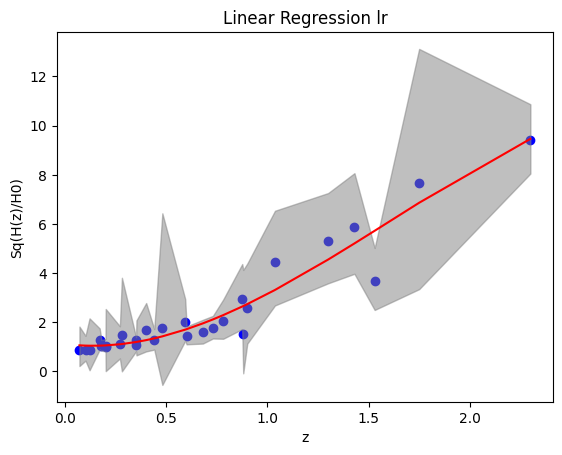

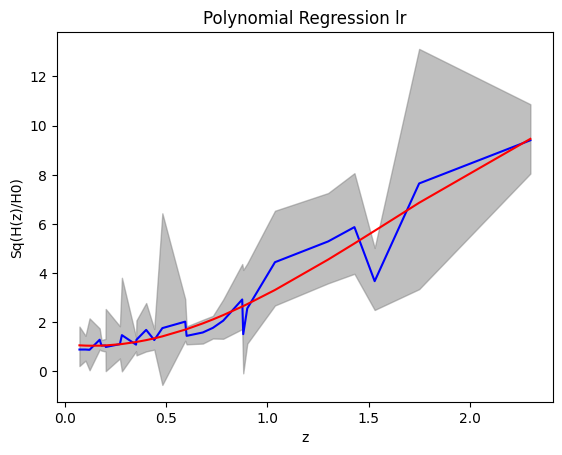

In [64]:
### Training a regression lr to predict the value of H(z) for a given redshift z
# Polynomial regression]
from sklearn.linear_model import LinearRegression

X = df[['a', 'b']]
y = df['hz0']

lr = LinearRegression()
lr.fit(X, y)

# find the coefficient of a and b, and the intercept
coeff_a, coeff_b, intercept = lr.coef_[0], lr.coef_[1], lr.intercept_
print(f'Coefficients of a and b: {coeff_a, coeff_b}')
print(f'Intercept: {intercept}')

X = df['z']
y = df['hz0']
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
X = X.values.reshape(-1, 1)
X_poly = poly.fit_transform(X)
lr = LinearRegression()

lr.fit(X_poly, y)
print(f'Coefficients of the polynomial regression lr: {lr.coef_}')
print(f'Intercept: {lr.intercept_}')
# y = c3*x^3 + c2*x^2 + c1*x + c0
c3, c2, c1, c0 = lr.coef_[2], lr.coef_[1], lr.coef_[0], lr.intercept_
print(f'c3, c2, c1, c0: {lr.coef_}, {lr.intercept_}')
print(f'Sq(H(z)/H0) = {c3}*z^3 + {c2}*z^2 + {c1}*z + {c0}')
# Plot the regression lr
plt.scatter(df['z'], df['hz0'], color='blue')
plt.plot(df['z'], lr.predict(X_poly), color='red')
plt.xlabel('z')
plt.ylabel('Sq(H(z)/H0)')
plt.fill_between(df['z'], df['hzl'], df['hzu'], color='gray', alpha=0.5)    
plt.title('Linear Regression lr')
plt.show()


# Plot the polynomial regression lr
plt.plot(df['z'], df['hz0'], color='blue')
plt.plot(df['z'], lr.predict(X_poly), color='red')
plt.xlabel('z')
plt.ylabel('Sq(H(z)/H0)')
plt.fill_between(df['z'], df['hzl'], df['hzu'], color='gray', alpha=0.5)    
plt.title('Polynomial Regression lr')
plt.show()





In [73]:
# Initialize the parameters with the values of m, k, and l, define loss function and use gradient descent to minimize the loss function
import torch
import torch.optim as optim
import torch.nn as nn

# Convert the data to tensors
z = torch.tensor(df['z'].values, dtype=torch.float32)
hz0 = torch.tensor(df['hz0'].values, dtype=torch.float32)
e = torch.tensor(df['e'].values, dtype=torch.float32)
# [ 0.17416501 -0.31063062  1.159686  ] initial values of m, k, and l

# Define the model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.m = nn.Parameter(torch.tensor(0.17416501, requires_grad=True))
        self.k = nn.Parameter(torch.tensor(-0.31063062, requires_grad=True))
        self.l = nn.Parameter(torch.tensor(1.159686, requires_grad=True))

        
    def forward(self, z):
        return (self.m*(1+z)**3 + self.k*(1+z)**2 + self.l)
    
model_0, model_1, model_2 = Model(), Model(), Model()

# Define the loss function
def loss_fn_0(y, y_pred, e):
    return torch.sum(abs(y - y_pred)/e**2)

def loss_fn_1(y, y_pred, e):
    loss = torch.zeros(len(y))
    for i in range(len(y)):
        if y_pred[i] > df['hz1'][i]:
            loss[i] = (y_pred[i] - df['hz1'][i])
        elif y_pred[i] < df['hz-1'][i]:
            loss[i] = (df['hz-1'][i] - y_pred[i])
        else:
            loss[i] = 0
    return torch.sum(loss)

def loss_fn_2(y, y_pred, e):
    loss = torch.zeros(len(y))
    for i in range(len(y)):
        if y_pred[i] > df['hz2'][i]:
            loss[i] = (y_pred[i] - df['hz2'][i])
        elif y_pred[i] < df['hz-2'][i]:
            loss[i] = (df['hz-2'][i] - y_pred[i])
        else:
            loss[i] = 0
    return torch.sum(loss)

# Define the optimizer
optimizer = optim.Adam([model_0.m, model_0.k, model_0.l], lr=0.01)


# Train the model
def train(model, z, hz0, e, loss_fn, optimizer, epochs=1000):
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(z)
        loss = loss_fn(hz0, y_pred, e)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 400 == 0:
            print('Epoch:', epoch+1, 'Loss:', loss.item())
    return model

model_0 = train(model_0, z, hz0, e, loss_fn_0, optimizer, epochs=2000)
model_1 = train(model_1, z, hz0, e, loss_fn_1, optimizer, epochs=2000)
model_2 = train(model_2, z, hz0, e, loss_fn_2, optimizer, epochs=2000)

# Report the best fit values of m, k, and l
print(f'For loss_0: m = {model_0.m.item()}, k = {model_0.k.item()}, l = {model_0.l.item()}')
print(f'For loss_1: m = {model_1.m.item()}, k = {model_1.k.item()}, l = {model_1.l.item()}')
print(f'For loss_2: m = {model_2.m.item()}, k = {model_2.k.item()}, l = {model_2.l.item()}')



Epoch: 400 Loss: 0.046964798122644424
Epoch: 800 Loss: 0.046802885830402374
Epoch: 1200 Loss: 0.04684140533208847
Epoch: 1600 Loss: 0.04655679315328598
Epoch: 2000 Loss: 0.04684387147426605
Epoch: 400 Loss: 20.305072784423828
Epoch: 800 Loss: 20.305072784423828
Epoch: 1200 Loss: 20.305072784423828
Epoch: 1600 Loss: 20.305072784423828
Epoch: 2000 Loss: 20.305072784423828
Epoch: 400 Loss: 17.849184036254883
Epoch: 800 Loss: 17.849184036254883
Epoch: 1200 Loss: 17.849184036254883
Epoch: 1600 Loss: 17.849184036254883
Epoch: 2000 Loss: 17.849184036254883
For loss_0: m = 0.3343597650527954, k = -0.29272544384002686, l = 0.9313953518867493
For loss_1: m = 0.1741650104522705, k = -0.3106306195259094, l = 1.1596859693527222
For loss_2: m = 0.1741650104522705, k = -0.3106306195259094, l = 1.1596859693527222


In [74]:
model_0 = train(model_0, z, hz0, e, loss_fn_0, optimizer, epochs=2000)
print(f'For loss_0: m = {model_0.m.item()}, k = {model_0.k.item()}, l = {model_0.l.item()}')


Epoch: 400 Loss: 0.04803946614265442
Epoch: 800 Loss: 0.04938133805990219
Epoch: 1200 Loss: 0.046500079333782196
Epoch: 1600 Loss: 0.046834200620651245
Epoch: 2000 Loss: 0.04697312414646149
For loss_0: m = 0.3233185112476349, k = -0.3001801073551178, l = 0.927348256111145


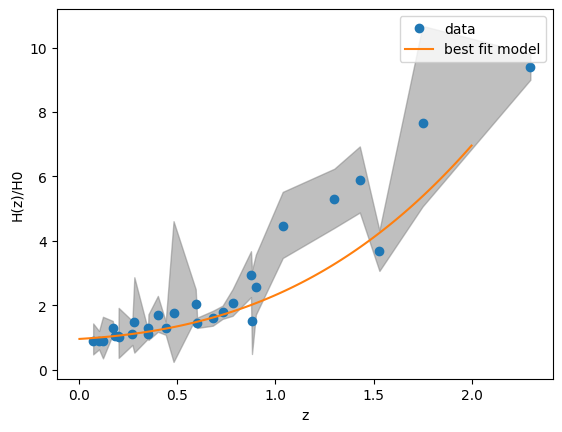

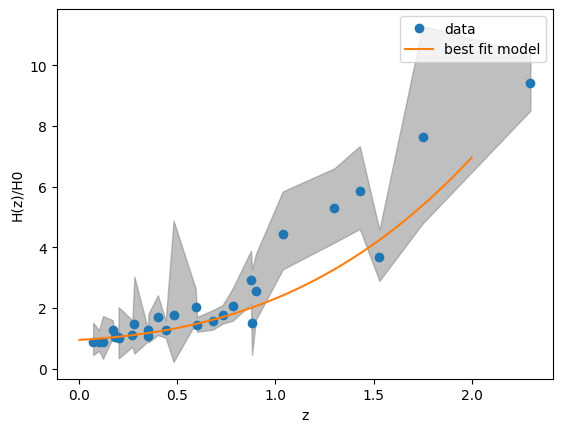

In [75]:
# For loss_0: m = -0.018983950838446617, k = 0.14773648977279663, l = 0.8314396739006042
m_final = model_0.m.item(); k_final = model_0.k.item(); l_final = model_0.l.item()
# m_final, k_final, l_final = -0.018983950838446617, 0.14773648977279663, 0.8314396739006042  

# Plot the data 
plt.plot(df['z'], df['hz0'], 'o', label='data')
z = np.linspace(0, 2, 100)
plt.plot(z, model(z, m_final, k_final, l_final), label='best fit model')
plt.fill_between(df['z'], df['hz-1'], df['hz1'], color='gray', alpha=0.5)
plt.xlabel('z')
plt.ylabel('H(z)/H0')
plt.legend()
plt.show()

# Plot the tolerance bands
plt.plot(df['z'], df['hz0'], 'o', label='data')
z = np.linspace(0, 2, 100)
plt.plot(z, model(z, m_final, k_final, l_final), label='best fit model')
plt.fill_between(df['z'], df['hz-2'], df['hz2'], color='gray', alpha=0.5)
plt.xlabel('z')
plt.ylabel('H(z)/H0')
plt.legend()
plt.show()


## Inbuilt method


In [76]:

# To find the best fit values of m, k, and l, we can use the least squares method.
from scipy.optimize import curve_fit

popt, pcov = curve_fit(model, df['z'], df['hz0'], sigma=df['e'], absolute_sigma=True)
print(popt)
print(np.sqrt(np.diag(pcov)))
print(f'value of m: {popt[0]} +/- {np.sqrt(pcov[0,0])}')
print(f'value of k: {popt[1]} +/- {np.sqrt(pcov[1,1])}')
print(f'value of l: {popt[2]} +/- {np.sqrt(pcov[2,2])}')

[0.18538385 0.22299174 0.37838579]
[1.76918853 6.22256534 7.52187394]
value of m: 0.18538385075663577 +/- 1.7691885305482016
value of k: 0.22299174063677957 +/- 6.222565339452787
value of l: 0.378385794319299 +/- 7.52187394161087


Best fit values of m, k, and l:[0.17394948 0.25353387 0.39313364]
Loss = 11.919106452171203
value of m: 0.17394948120434472
value of k: 0.25353386991145194
value of l: 0.3931336429818136
Ul loss: 0.0
 Loss_2 = 1.2001290815751877


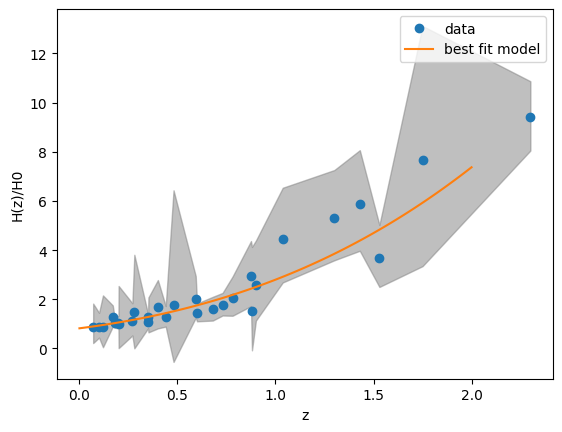

Best fit values of m, k, and l:[0.1897385  0.24584552 0.30738501]
Loss = 2.417110304286499
value of m: 0.18973850488268612
value of k: 0.24584551909807276
value of l: 0.3073850105664125
Ul loss: 0.0
 Loss_2 = 1.1696912600699134


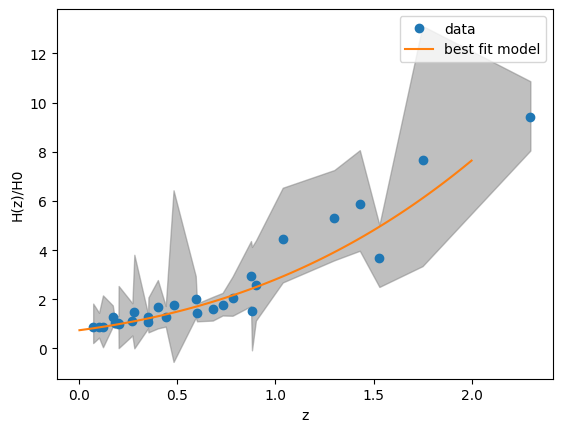

Best fit values of m, k, and l:[ 0.03312802  0.70322833 -0.1032277 ]
Loss = 0.659246593548607
value of m: 0.033128018485257864
value of k: 0.703228328625719
value of l: -0.10322769948983172
Ul loss: 0.00016237151373421632
 Loss_2 = 1.178853897192937


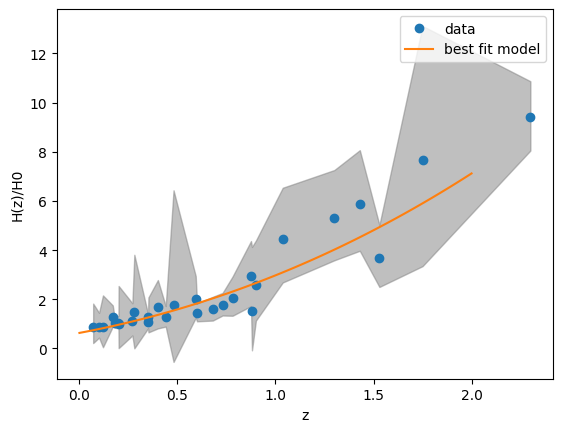

Best fit values of m, k, and l:[0.20347924 0.22031755 0.3860672 ]
Loss = 1.03077630923956
value of m: 0.20347924068224138
value of k: 0.22031754794110636
value of l: 0.3860672046043065
Ul loss: 0.06620896797396103
 Loss_2 = 1.03077630923956


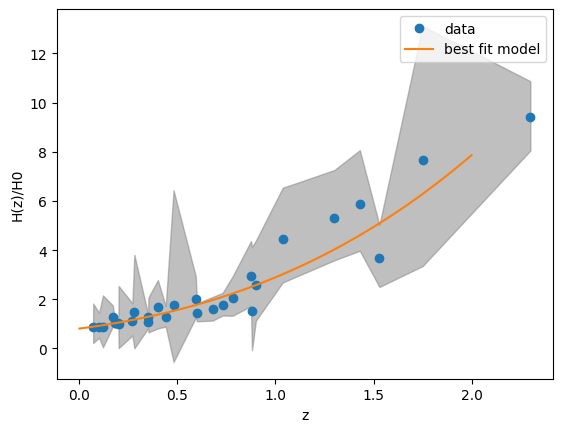

In [84]:
from scipy.optimize import minimize
def performance_of_loss(loss, popt):
    result = minimize(loss, popt)
    print(f'Best fit values of m, k, and l:{result.x}')
    print(f'Loss = {loss(result.x)}')

    # print the best fit values of m, k, and l
    print(f'value of m: {result.x[0]}')
    print(f'value of k: {result.x[1]}')
    print(f'value of l: {result.x[2]}')


    print(f'Ul loss: {loss_ul(result.x)}')
    print(f' Loss_2 = {loss_2(result.x)}')
    plot_tolerances(*result.x)
'''
    # plot the data and the best fit model
    plt.errorbar(df['z'], df['hz0'], yerr=df['e'], fmt='o', label='data')
    z = np.linspace(0, 2, 100)
    plt.plot(z, model(z, *result.x), label='best fit model')
    plt.xlabel('z')
    plt.ylabel('H(z)/H0')
    plt.legend()
    plt.show()

    # plot the residuals
    plt.errorbar(df['z'], model(df['z'], *result.x) - df['hz0'], yerr=df['e'], fmt='o')
    plt.axhline(0, color='black', lw=1)
    plt.xlabel('z')
    plt.ylabel('residuals')
    plt.show()
'''
performance_of_loss(loss_0, popt)
performance_of_loss(loss_1, popt)
performance_of_loss(loss_1_5, popt)
performance_of_loss(loss_2, popt)

In [ ]:
# To find the value by definig=ng a loss function and minimizing it
def loss_1(params):
    m, k, l = params
    # return np.sum(((model(df['z'], m, k, l) - df['hz0'])/df['e'])**2)
    # if value lies between the error bars, the loss is 0
    # if value is more than the upper error bar, the loss is (value - upper error bar), else (lower error bar - value)
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))

    for i in range(len(v)):
        if v[i] > df['hz1'][i]:
            loss[i] = (v[i] - df['hz1'][i])
        elif v[i] < df['hz-1'][i]:
            loss[i] = (df['hz-1'][i] - v[i])
        else:
            loss[i] = 0
    return np.sum(loss)

    
performance_of_loss(loss, popt)

In [ ]:
# To find the value by definig=ng a loss function and minimizing it
def loss(params):
    m, k, l = params
    # return np.sum(((model(df['z'], m, k, l) - df['hz0'])/df['e'])**2)
    # if value lies between the error bars, the loss is 0
    # if value is more than the upper error bar, the loss is (value - upper error bar), else (lower error bar - value)
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))

    for i in range(len(v)):
        loss[i] = abs(v[i] - df['hz0'][i])
    return np.sum(loss)
    
performance_of_loss(loss, popt)

